Wstęp

W niniejszym projekcie wykorzystano zbiór danych "lalonde" z biblioteki MatchIt. Dane składają się ze zmiennych demograficznych takich jak wiek, rasa, wykształcenie i wcześniejsze rzeczywiste zarobki, a także treatment indicator i rzeczywiste zarobki w 1978 roku. Celem było przeprowadzenie symulacyjnego badania wybranych estymatorów, natomiast celem symulacji było oszacowanie średniej wartości wybranej zmiennej w populacji. Estymatory, które wybrano do badania to estymator post-stratyfikacyjny oraz kalibracyjny.

Metodyka

W badaniu zdecydowano się na quasi-randomizacyjne metody estymacji prób nielosowych, a dokładniej estymatory kalibracyjne, w których konstruowane są pseudo-wagi z
wykorzystaniem próby losowej lub znanych/estymowanych
wartości globalnych. Estymatory kalibracyjne charakteryzują się mniejszym obciążeniem i wariancją w porównaniu do estymatorów znanych z klasycznej metody reprezentacyjnej i dostarczają wiarygodniejszych wyników w przypadku licznych braków odpowiedzi. Pierwszym wybranym estymatorem jest klasyczna kalibracja, a drugim post-stratyfikacja, która jest szczególnym przypadkiem kalibracji.

##Opis symulacji

Na wstępie symulacji zostaje obliczona prawdziwa wartość średniej realnych zarobków w 1978 roku. Jest ona wyznaczana dla całej populacji. 

Następnie wygenerowana zostaje próba losowa oraz próba nielosowa. Próba nielosowa stanowi 25% całej populacji i jest ona losowana proporcjonalnie do wielkości realnych zarobków w 1978 roku. Wielkość próby losowej została ustawiona na 153, tak aby rozmiary obu grup były jednakowe. 

W każdej iteracji obliczony zostaje estymator naiwny oraz dwa estymatory korygujące błędy losowe - post-stratyfikacyjny oraz kalibracyjny. 

Dla kazdego estymatora obliczona zostaje średnia wartość zmiennej re78. 



##Symulacja

In [ ]:
install.packages("tidyverse")
install.packages("survey")
install.packages("MatchIt")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘minqa’, ‘numDeriv’, ‘mitools’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppProgress’




In [ ]:
library(ggplot2)
library(survey)
library(tidyverse)
library(MatchIt)

Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: ‘survey’


The following object is masked from ‘package:graphics’:

    dotchart


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()



 **Import danych**

In [ ]:
data(lalonde)
head(lalonde)

,treat,age,educ,race,married,nodegree,re74,re75,re78
,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
NSW1,1,37,11,black,1,1,0,0,9930.0460
NSW2,1,22,9,hispan,0,1,0,0,3595.8940
NSW3,1,30,12,black,0,0,0,0,24909.4500
NSW4,1,27,11,black,0,1,0,0,7506.1460
NSW5,1,33,8,black,0,1,0,0,289.7899
NSW6,1,22,9,black,0,1,0,0,4056.4940


Przekształcenie zmiennych *nodegree* oraz *treat* ze zmiennych liczbowych na zmienne kategorialne

In [ ]:
dane <- lalonde %>%
    mutate(nodegree = as.factor(nodegree), treat = as.factor(treat))
tail(dane)


,treat,age,educ,race,married,nodegree,re74,re75,re78
,<fct>,<int>,<int>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>
PSID424,0,25,14,white,0,0,0,0,0.0000
PSID425,0,18,11,white,0,1,0,0,10150.5000
PSID426,0,24,1,hispan,1,1,0,0,19464.6100
PSID427,0,21,18,white,0,0,0,0,0.0000
PSID428,0,32,5,black,1,1,0,0,187.6713
PSID429,0,16,9,white,0,1,0,0,1495.4590


In [ ]:
#średnia wartość zmiennej re78 (realnych zarobków w 1978 roku)
re78_prawdziwa <- mean(dane$re78)
re78_prawdziwa

B <- 100
wyniki_naiwny <- numeric(B)
wyniki_ps <- numeric(B)
wyniki_calib <- numeric(B)
total_rows <- nrow(dane)
n_losowa <- 153

#wartości globalne
globalne <- xtabs(~ race + nodegree, data = dane)

for (b in 1:B) {
  #tworzenie próby nielosowej
  set.seed(b)
  nielos_id <- sample(x = 1:total_rows, size = 0.25*total_rows, 
                      prob = dane$re78/sum(dane$re78))
  #wybieram rekordy
  nielosowa <- dane[nielos_id, ]


  losowa_id <- sample(x = 1:total_rows, size=n_losowa)
  losowa <- dane[losowa_id, ]

  #estymator naiwny dla próby nielosowej
  wyniki_naiwny[b] <- mean(nielosowa$re78)

  #POST-STRATYFIKACJA
  #przygotowanie do post-stratyfikcji - tworzenie obiektu design na danych z próby nielosowej
  svydes <- svydesign(ids = ~1, data = nielosowa, weights = ~1)

  #post-stratyfikacja - tworzenie nowego obiektu design, który uwzględnia wagi post-stratyfikacyjne
  svydes_post <- postStratify(svydes, ~ race + nodegree, globalne)
  
  #estymator post-stratyfikacyjny z wykorzystaniem funkcji svymean
  wyniki_ps[b] <- svymean(~ re78, svydes_post)[1]


  #KALIBRACJA
  global_race <- xtabs(~ race, data = dane)
  global_nodegree <- xtabs(~ nodegree, data = dane)

  #przygotowanie do kalibracji - tworzenie obiektu design na danych z próby nielosowej
  svy_nielos <- svydesign(ids = ~1, weight = ~1, data = nielosowa)

  #kalibracji dokonujemy niezależnie dla zmiennej race i nodegree
  svy_nielos_calib <- calibrate(
    design = svy_nielos,
    formula = list(~ race, ~ nodegree), 
    population = list(global_race,global_nodegree))

  wyniki_calib[b] <- svymean(~re78, svy_nielos_calib)

}
wyniki_naiwny[b]
wyniki_ps[b]
wyniki_calib[b]

#wartości z próby nielosowej
svytable(~race, svy_nielos)
svytable(~nodegree, svy_nielos)

#weryfikacja o ile razy uzyskane dane różnią się populacji 
global_race /svytable(~race, svy_nielos)
global_nodegree / svytable(~nodegree, svy_nielos)

#weryfikacja czy kalibracja zadziałała
svytotal(~race, svy_nielos_calib)
global_race



[1] 6792.834

[1] 13646.59

[1] 13322.01

[1] 13332.39

race
 black hispan  white 
    53     17     83 

nodegree
 0  1 
72 81 

race
   black   hispan    white 
4.584906 4.235294 3.602410 

nodegree
       0        1 
3.152778 4.777778 

           total SE
raceblack    243  0
racehispan    72  0
racewhite    299  0

race
 black hispan  white 
   243     72    299 

In [ ]:
#porównanie jak bardzo wagi się zmieniły 
summary(weights(svy_nielos_calib)/weights(svy_nielos))

#średnio wagi były przemnożone 4 razy 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.885   2.885   4.452   4.013   4.604   5.265 

In [ ]:
svymean(~re78, svy_nielos) #bez kalibracji
svymean(~re78, svy_nielos_calib) #z kalibracją race i nodegree

      mean    SE
re78 13647 659.7

      mean     SE
re78 13332 708.98

In [ ]:
wyniki <- data.frame(naive_oczekiwana = mean(wyniki_naiwny), 
                     naive_odchyl = sd(wyniki_naiwny), 
                     naive_obciazenie = mean(wyniki_naiwny) - re78_prawdziwa,
                     post_oczekiwana = mean(wyniki_ps), 
                     post_odchyl = sd(wyniki_ps), 
                     post_obciazenie = mean(wyniki_ps) - re78_prawdziwa,
                     calib_oczekiwana = mean(wyniki_calib),
                     calib_odchyl = sd(wyniki_calib),
                     calib_obciazenie = mean(wyniki_calib) - re78_prawdziwa,
                     re78_prawdziwa = re78_prawdziwa
                     
)
wyniki

naive_oczekiwana,naive_odchyl,naive_obciazenie,post_oczekiwana,post_odchyl,post_obciazenie,calib_oczekiwana,calib_odchyl,calib_obciazenie,re78_prawdziwa
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13447.37,407.6595,6654.534,13306.66,406.925,6513.826,13294.12,408.0906,6501.287,6792.834


Wykres przedstawia jak zmieniły się wagi pod wpływem kalibracji. 

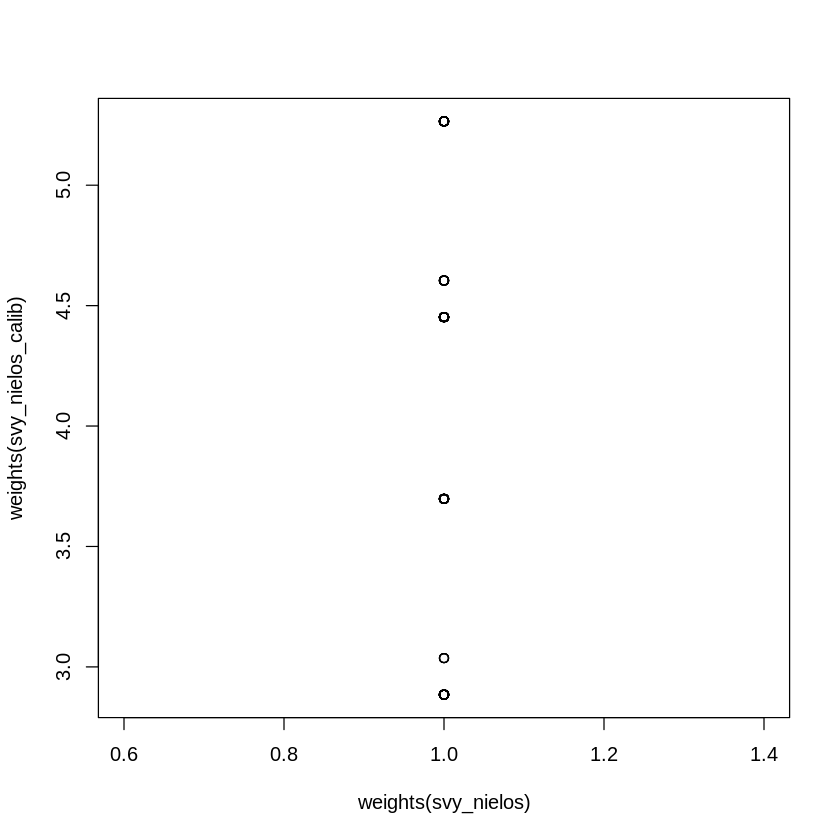

In [ ]:
plot(weights(svy_nielos), weights(svy_nielos_calib))

##Wyniki

Wartość prawdziwa średniej wartości zmiennej re78 tj. realnych zarobków w 1978 roku wyniosła 6792,83.
Estymator naiwny dla tej zmiennej na podstawie próby nielosowej wyniósł 13447,37.

W celu obliczenia kolejnego estymatora, wykonano post-stratyfikację, estymator ten przyjął wartość równą 13322,01.

W badaniu dokonano również kalibracji oddzielnie dla zmiennej *race* oraz zmiennej *nodegree*. Próba nielosowa zawierała 153 obiekty, a wartości poszczególnych kategorii obu zmiennych prezentowały się następująco:


> Race:
*   black:   53
*   hispan:  17
*   white:   83


> Nodegree
*   0: 72
*   1: 81

Następnie obliczono estymator średniej wartości zmiennej *re78*, która wyniosła 13332,38. Dla porównania, przed zastosowaniem kalibracji, wynik ten był równy 13647 dla próby nielosowej.

W kolejnym kroku zweryfikowano jak uzyskane dane w próbie losowej różnią się od populacji. W tym celu obliczono stosunek wartości globalnych dla poszczególnych zmiennych w próbie losowej do wartości uzyskanych w próbie nielosowej. Dla obu zmiennych stosunki te oscylowały od 2,6 do 3,8. 

Po przeprowadzonej kalibracji wagi zmieniły się średnio 4 razy. 

Na podstawie przeprowadzonego badania symulacyjnego dla każdego estymatora obliczono wartość oczekiwaną, odchylenie standardowe oraz obciążenie. W efekcie uzyskano następujące wyniki:


> Wartość oczekiwana:


*   estymator naiwny:                13447.37
*   estymator post-stratyfikacyjny:  13306.66
*   estymator kalibracyjny: 13294.12



> Odchylenie standardowe:

*   estymator naiwny:                407.6595
*   estymator post-stratyfikacyjny:  406.925
*   estymator kalibracyjny: 408.0906


> Obciążenie:

*   estymator naiwny:                6654.534
*   estymator post-stratyfikacyjny:  6513.826
*   estymator kalibracyjny: 6501.287

Wartości oczekiwane są bardzo zbliżone do tych uzyskanych podczas symulacji.
Odchylenie standardowe dla estymatorów jest dosyć duże,co świadczy o tym, że wartości zmiennej *re78* są silnie rozproszone wokół średniej, są mocno zróżnicowane. 
Najmniejsze obciążenie uzyskano w przypadku estymatora kalibracyjnego.






Podsumowanie

Występujące różnice pomiędzy estymatorem naiwnym oraz post-stratyfikacyjnym wskazują, że zmienna *re78* wykorzystana do post-stratyfikacji działa, bo różnicuje populację.

Zastosowana kalibracja przybliżyła wyglądem próbę do populacji, przez co umożliwiła poprawę efektywności uzyskanych wyników.  
